# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

INFO: pip is looking at multiple versions of tensorflow-gpu to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


ERROR: Requested tensorflow-gpu from https://files.pythonhosted.org/packages/8a/45/fa31ced1db38f9424f262dfbf35747fe5378b5c808cecb373c8cb8e515d3/tensorflow-gpu-2.12.0.tar.gz has invalid metadata: Expected end or semicolon (after name and no valid version specifier)
    python_version>"3.7"
                  ^


In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.5.0
certifi                      2024.8.30
charset-normalizer           3.4.0
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.7
decorator                    5.1.1
exceptiongroup               1.2.2
executing                    2.1.0
flatbuffers                  24.3.25
fonttools                    4.54.1
gast                         0.4.0
google-auth                  2.35.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.67.0
h5py                         3.12.1
idna                         3.10
ipykernel                    6.29.5
ipython                      8.28.0
jedi                         0.19.1

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data'
num_classes = len(os.listdir(data_dir)) 
print(f"Number of classes: {num_classes}")

Number of classes: 3


In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 348 files belonging to 3 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

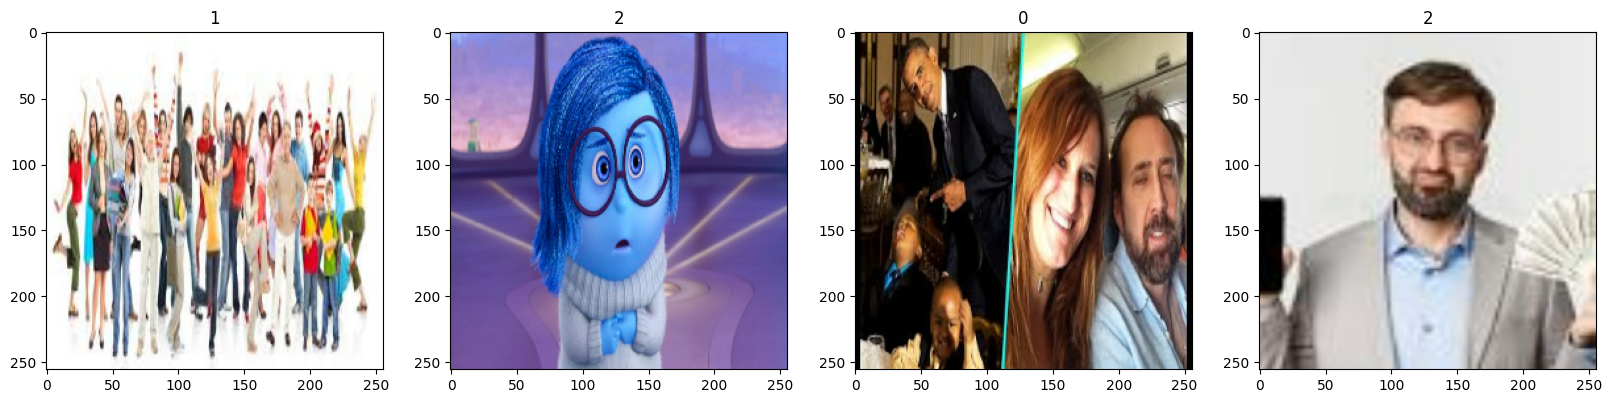

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.1764706 , 0.14509805, 0.19607843],
          [0.1764706 , 0.14509805, 0.19607843],
          [0.1764706 , 0.14509805, 0.19607843],
          ...,
          [0.14509805, 0.12156863, 0.16862746],
          [0.14509805, 0.12156863, 0.16862746],
          [0.14509805, 0.12156863, 0.16862746]],
 
         [[0.1764706 , 0.14509805, 0.19607843],
          [0.1764706 , 0.14509805, 0.19607843],
          [0.1764706 , 0.14509805, 0.19607843],
          ...,
          [0.14577205, 0.12224264, 0.16930147],
          [0.14577205, 0.12224264, 0.16930147],
          [0.14577205, 0.12224264, 0.16930147]],
 
         [[0.1764706 , 0.14509805, 0.19607843],
          [0.1764706 , 0.14509805, 0.19607843],
          [0.1764706 , 0.14509805, 0.19607843],
          ...,
          [0.14883578, 0.12530637, 0.1723652 ],
          [0.14883578, 0.12530637, 0.1723652 ],
          [0.14883578, 0.12530637, 0.1723652 ]],
 
         ...,
 
         [[0.20186888, 0.1234375 , 0.13128063],
          [0.20202

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

c:\Users\Mahitha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,139 (14.10 MB)

 Trainable params: 3,697,139 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.4847 - loss: 2.1315 - val_accuracy: 0.3750 - val_loss: 1.2439
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.4607 - loss: 1.0605 - val_accuracy: 0.4219 - val_loss: 1.0328
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.4905 - loss: 1.0219 - val_accuracy: 0.7188 - val_loss: 0.8724
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.6526 - loss: 0.8435 - val_accuracy: 0.6562 - val_loss: 0.7253
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.6934 - loss: 0.7643 - val_accuracy: 0.5938 - val_loss: 0.8463
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.7131 - loss: 0.6640 - val_accuracy: 0.7656 - val_loss: 0.6350
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.8153 - loss: 0.5909 - val_accuracy: 0.8281 - val_loss: 0.4930
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.8363 - loss: 0.4915 - val_accuracy: 0.7500 - val_loss:

# 8. Plot Performance

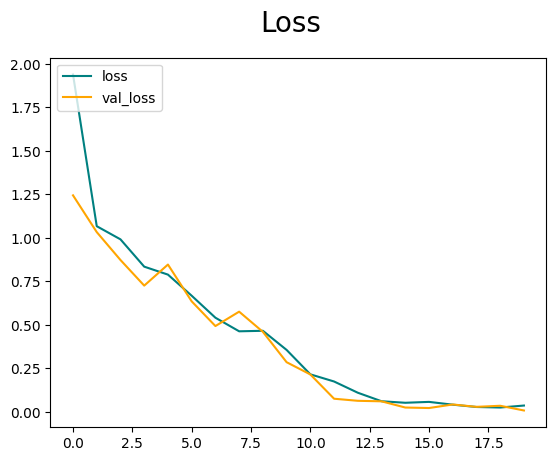

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

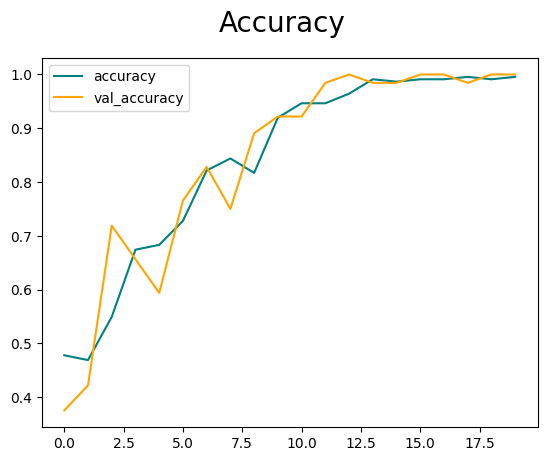

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = tf.keras.metrics.SparseCategoricalAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(tf.argmax(y, axis=-1),tf.argmax(yhat, axis=-1))
    re.update_state(tf.argmax(y, axis=-1),tf.argmax(yhat, axis=-1))
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.875, shape=(), dtype=float32) tf.Tensor(0.9375, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

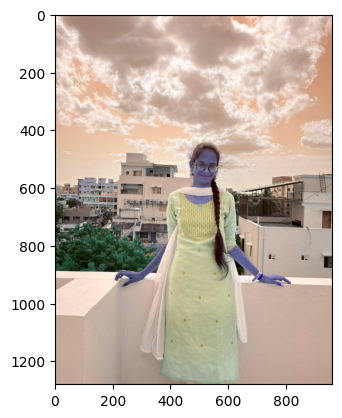

In [36]:
img = cv2.imread('mahithahappy.jpg')
plt.imshow(img)
plt.show()

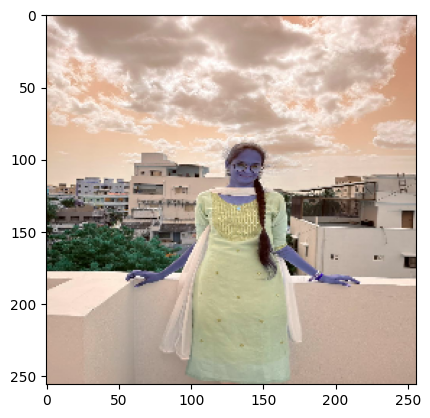

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [39]:
yhat

array([[0.00107543, 0.9964296 , 0.00249495]], dtype=float32)

In [40]:
import numpy as np

if np.argmax(yhat) == 0:  # If the first class has the highest probability
    print('Predicted class is Surprise')
elif np.argmax(yhat) == 1:  # If the second class has the highest probability
    print('Predicted class is Happy')
elif np.argmax(yhat) == 2:  # If the third class has the highest probability
    print('Predicted class is Sad')


Predicted class is Happy


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))